In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from datasets import load_dataset
import seaborn as sns

In [2]:
from data import *
train_df, val_df, test_df = make_base_dataset()

Found cached dataset humicroedit (/home/gabriel/.cache/huggingface/datasets/humicroedit/subtask-1/0.0.0/209c209bc70671d8d939aefd82e51f8ff294e47504ec64ef653a93a1f13e9ed3)


  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
df = train_df

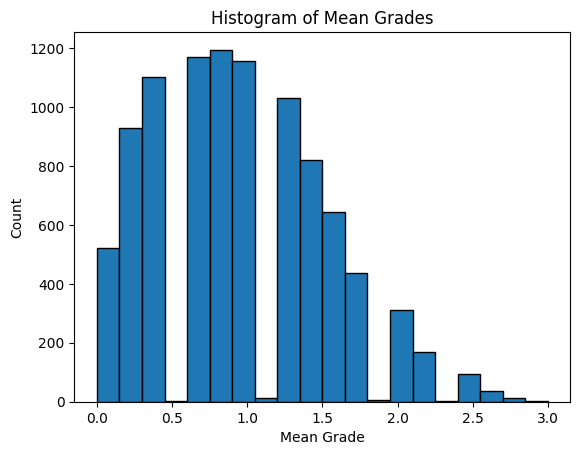

In [4]:
# 1. Histogram of mean grades
plt.hist(df['meanGrade'], bins=20, edgecolor='black')
plt.title('Histogram of Mean Grades')
plt.xlabel('Mean Grade')
plt.ylabel('Count')
plt.show()

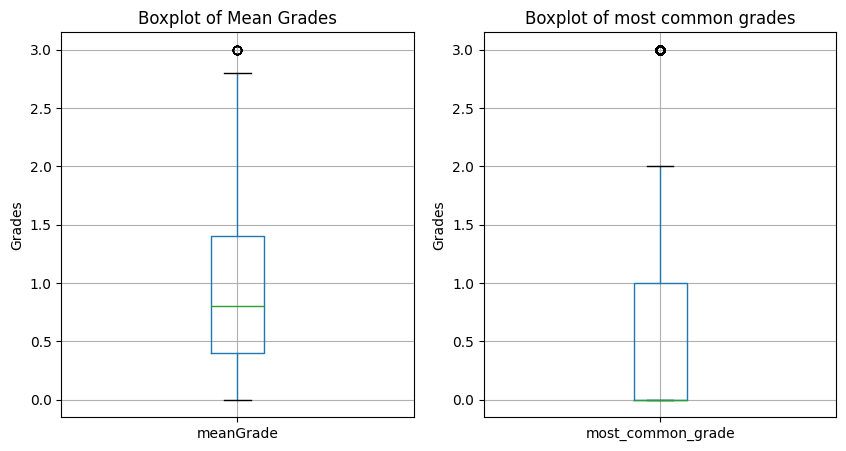

In [35]:
# Flatten the grades data
flat_data = df.explode('grades')

# Convert 'grades' to numeric
flat_data['grades'] = pd.to_numeric(flat_data['grades'])

# Boxplot of grades
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

flat_data.boxplot(column='meanGrade', ax=ax[0])
ax[0].set_title('Boxplot of Mean Grades')
ax[0].set_ylabel('Grades')

flat_data.boxplot(column='most_common_grade', ax=ax[1])
ax[1].set_title('Boxplot of most common grades')
ax[1].set_ylabel('Grades')
plt.show()

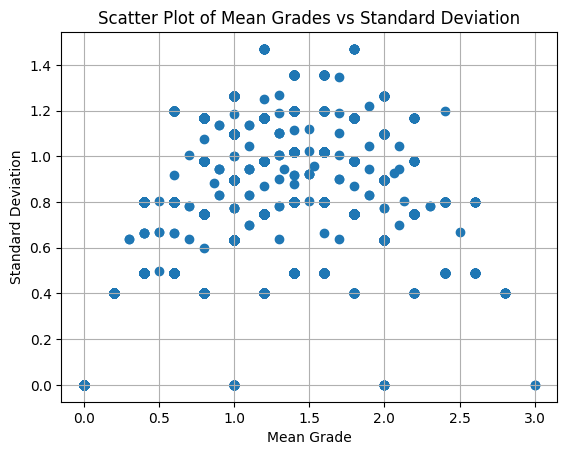

In [6]:
# 3. Scatter plot of mean grades vs standard deviation of grades
plt.scatter(df['meanGrade'], df['stddev'])
plt.title('Scatter Plot of Mean Grades vs Standard Deviation')
plt.xlabel('Mean Grade')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()

In [19]:
# Print 5 funniest lines
print("\n5 Funniest Lines:")
funniest = df.sort_values(by='meanGrade', ascending=False).head(5)
for i, row in funniest.iterrows():
    print(f"{row['arrow_sentence']}, Mean Grade: {row['meanGrade']}")

# Print 5 least funny lines
print("\n5 Least Funny Lines:")
least_funny = df.sort_values(by='meanGrade').head(5)
for i, row in least_funny.iterrows():
    print(f"{row['arrow_sentence']}, Mean Grade: {row['meanGrade']}")

# Print 5 lines with biggest variance
print("\n10 Lines With Biggest Variance:")
biggest_variance = df.sort_values(by='stddev', ascending=False).head(10)
for i, row in biggest_variance.iterrows():
    print(f"{row['arrow_sentence']}, Mean: {row['meanGrade']}, Std Dev: {row['stddev']}")



5 Funniest Lines:
Recent Scandals Highlight Trump 's Chaotic [ Management => Fashion ] Style, Mean Grade: 3.0
President Trump 's first year [ anniversary => Kindergarten ] report card , with grades from A + to F, Mean Grade: 3.0
How an FBI raid fed a rumor that Orrin Hatch was about to become [ president => pregnant ] , Mean Grade: 2.799999952316284
Trump admits tariffs could cause ' pain ' in [ markets => buttock ] , Mean Grade: 2.799999952316284
Kasich : Trump [ tweets => hair ] ‘ unacceptable ’, Mean Grade: 2.799999952316284

5 Least Funny Lines:
Carson proposes that poor should [ pay => forgo ] more rent, Mean Grade: 0.0
Central Michigan University On Lockdown After [ Shooting => stabbing ] At Dorm Kills 2, Mean Grade: 0.0
 [ Devin Nunes => dogs ] tried to discredit the FBI . Instead , he proved it ’s onto something ., Mean Grade: 0.0
What happened to jarred closed [ testimony => book ] , Mean Grade: 0.0
Putin 's dilemma : Scrap [ term => credit ] limits or choose a successor, Mea

[-0.00146969  0.36742346  0.73484692  1.10227038  1.46969385]
['low', 'medium-low', 'medium-high', 'high']
Categories (4, object): ['low' < 'medium-low' < 'medium-high' < 'high']


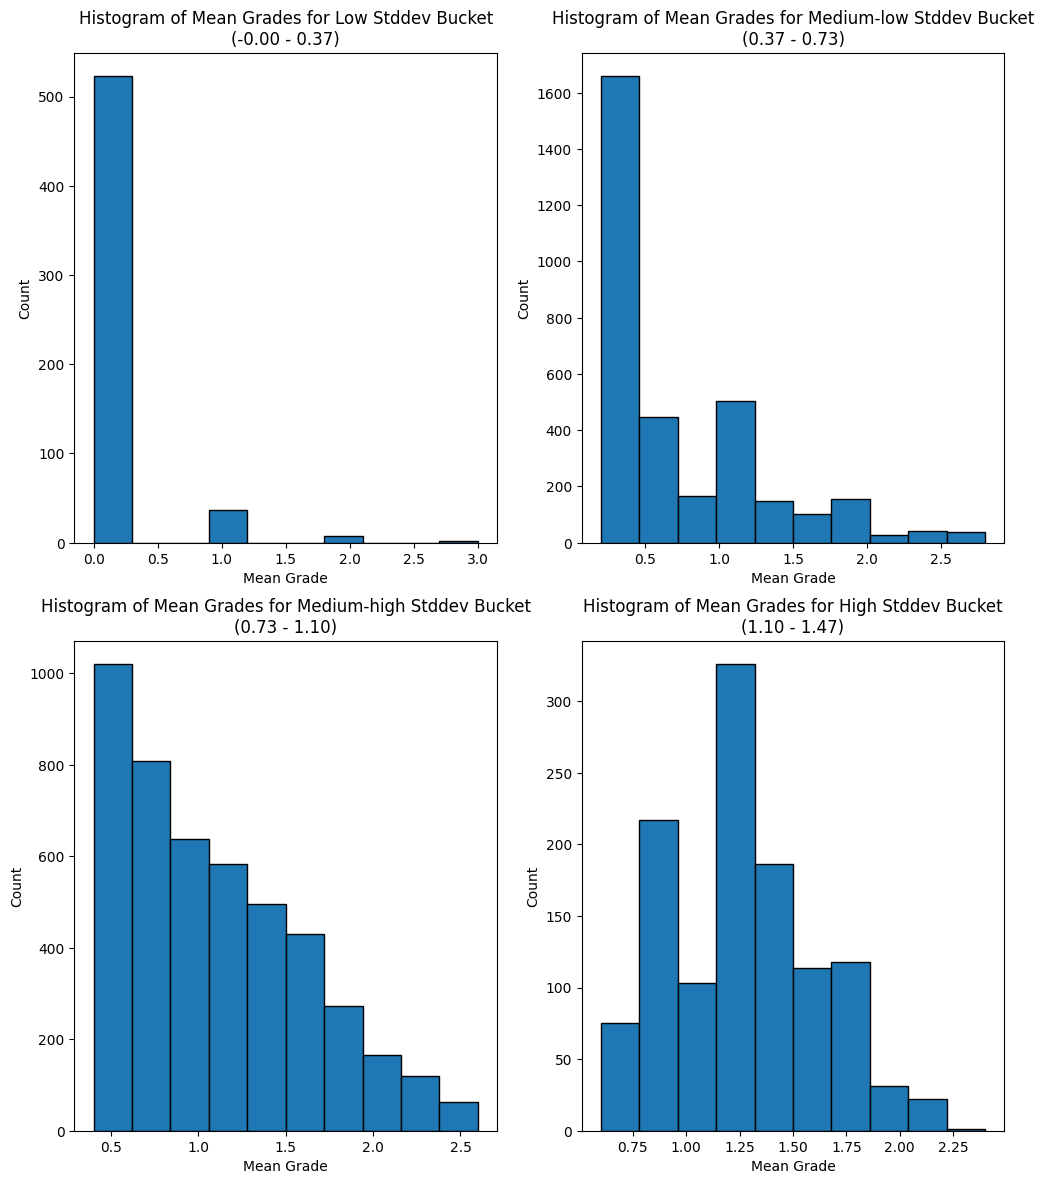

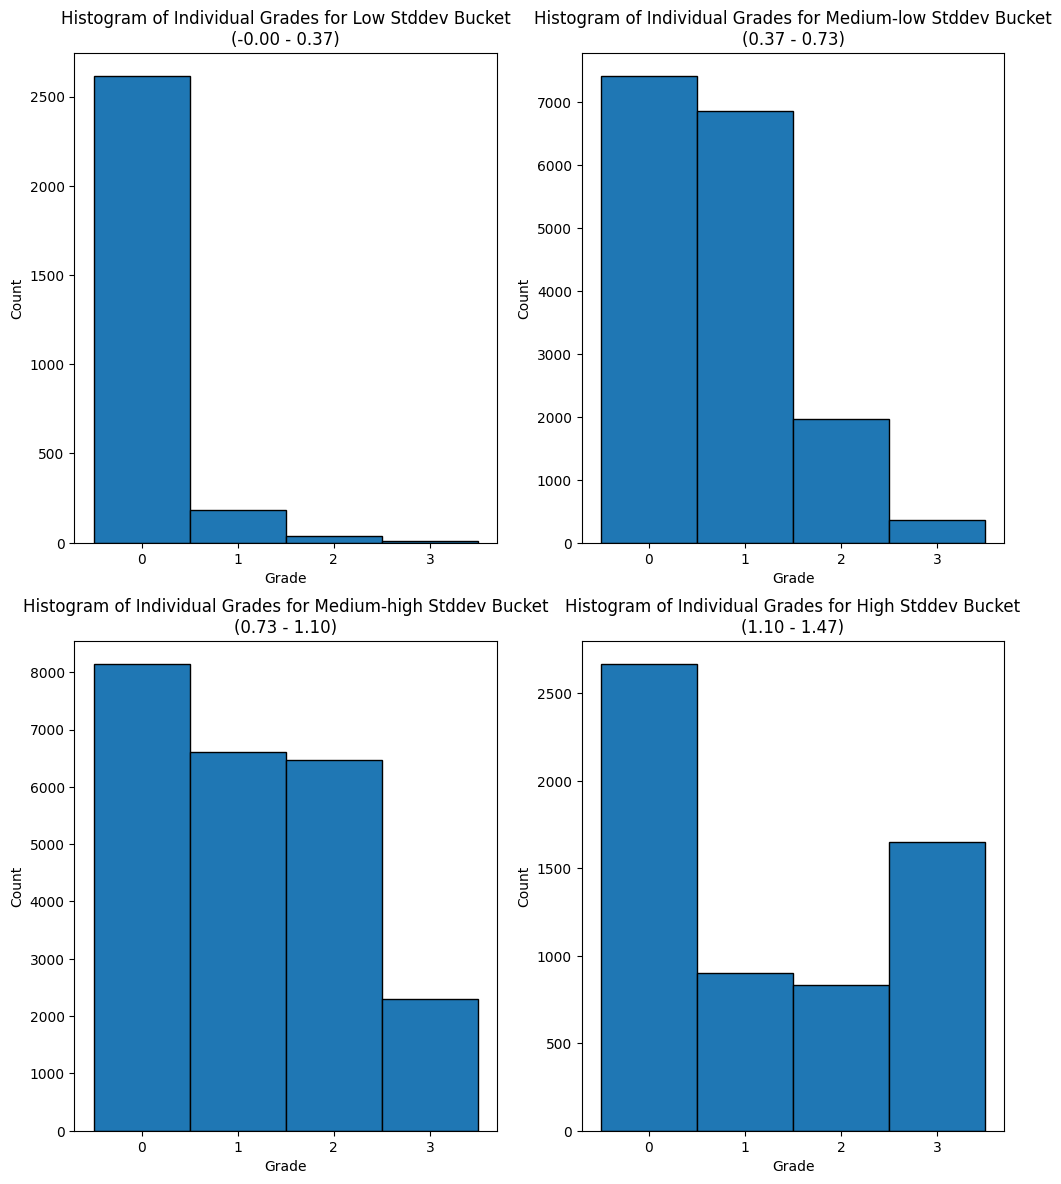

In [8]:
# 1. Bucketize stddev into 4 bins
df['stddev_bucket'], bins = pd.cut(df['stddev'], bins=4, retbins=True, labels=["low", "medium-low", "medium-high", "high"])

# Get unique labels
labels = df['stddev_bucket'].unique().sort_values()

print(bins)
print(labels)

# 2. Create a histogram of mean grades for each stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
i = 0
for i in range(len(labels)):
    label = labels[i]
    bin_from, bin_to = bins[i], bins[i + 1]
    axs[i // 2, i % 2].hist(df[df['stddev_bucket'] == label]['meanGrade'], bins=10, edgecolor='black')
    axs[i // 2, i % 2].set_title(f'Histogram of Mean Grades for {label.capitalize()} Stddev Bucket\n({bin_from:.2f} - {bin_to:.2f})')
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    i += 1
plt.show()

# 3. Plot a histogram of all individual grades for rows that fall into a particular stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
i = 0
for i in range(len(labels)):
    label = labels[i]
    bin_from, bin_to = bins[i], bins[i + 1]
    grades_in_bucket = df[df['stddev_bucket'] == label]['grades']
    grades_in_bucket = [item for sublist in grades_in_bucket for item in sublist]  # flatten list of lists

    axs[i // 2, i % 2].hist(grades_in_bucket, bins=range(5), edgecolor='black', align='left')
    axs[i // 2, i % 2].set_title(f'Histogram of Individual Grades for {label.capitalize()} Stddev Bucket\n({bin_from:.2f} - {bin_to:.2f})')
    axs[i // 2, i % 2].set_xlabel('Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    axs[i // 2, i % 2].set_xticks(range(4))
    i += 1
plt.show()


In [9]:
import json

try:
    
    with open('train_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        h = o
        headlines.append(h)

    # Define the topics you want to classify the headlines into
    topics = ["Business", "Science", "Health", "Politics", "Democrats", "Republicans", "Trump", "Biden", "Economy", "Sports", "Entertainment", "Technology", "Education", "World", "US", "Crime"]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['topics'] = ''

    batch_size = 1000
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            #print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}" \nBest Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['topics']

    with open('train_topics_cache.txt', 'w') as f:
        json.dump(topics, f)


try:
    with open('train_edit_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['edit_topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        #h = o
        h = e
        headlines.append(h)

    # Define the topics you want to classify the funny words
    topics = ["sexual", "bodypart", "family", "food", "trump", "politics", "children", "clothes", "fashion", "animals" , "drugs", "silly", "places", "profession", "disease", "relationships", "aging", "money" ]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['edit_topics'] = ''

    batch_size = 100
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}", Best Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'edit_topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['edit_topics']

    with open('train_edit_topics_cache.json', 'w') as f:
        json.dump(topics, f)

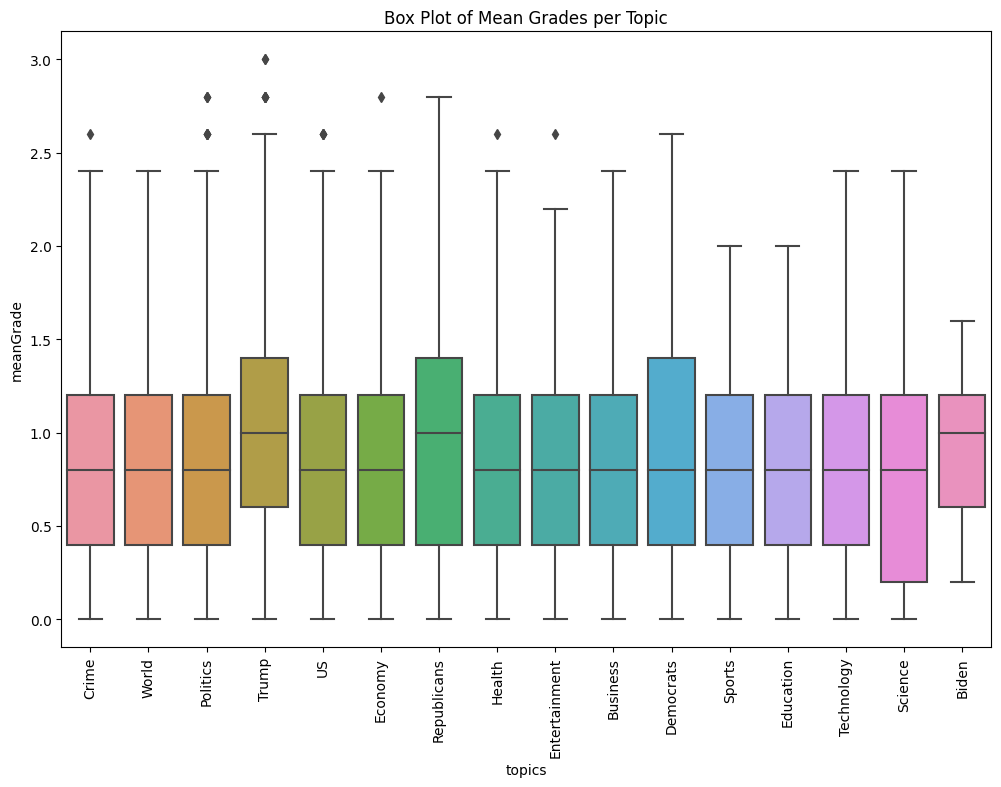

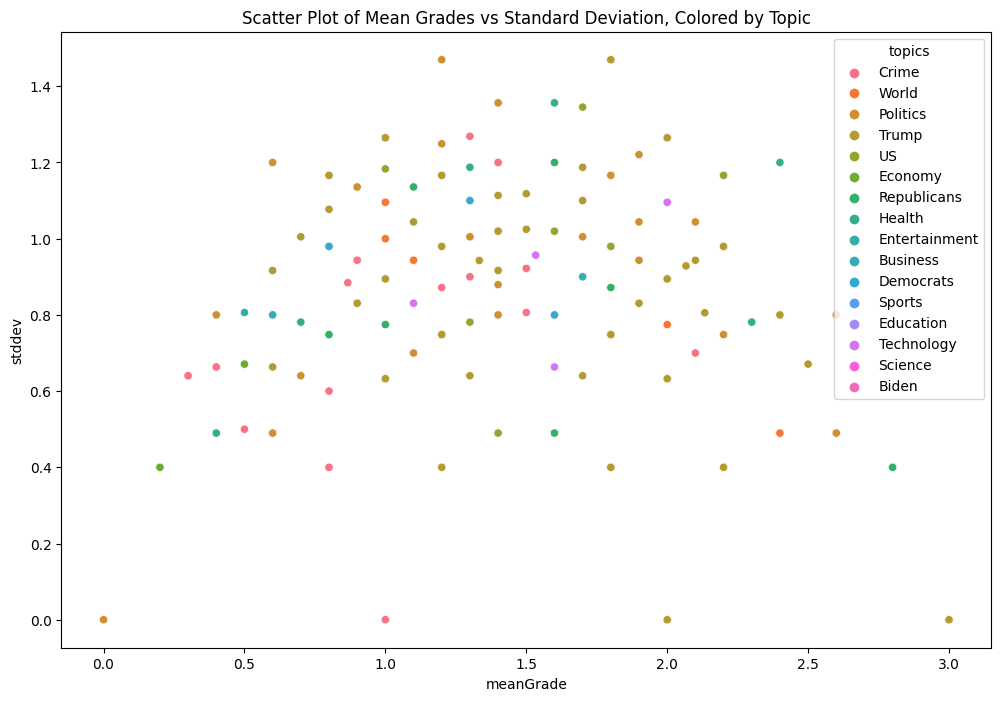

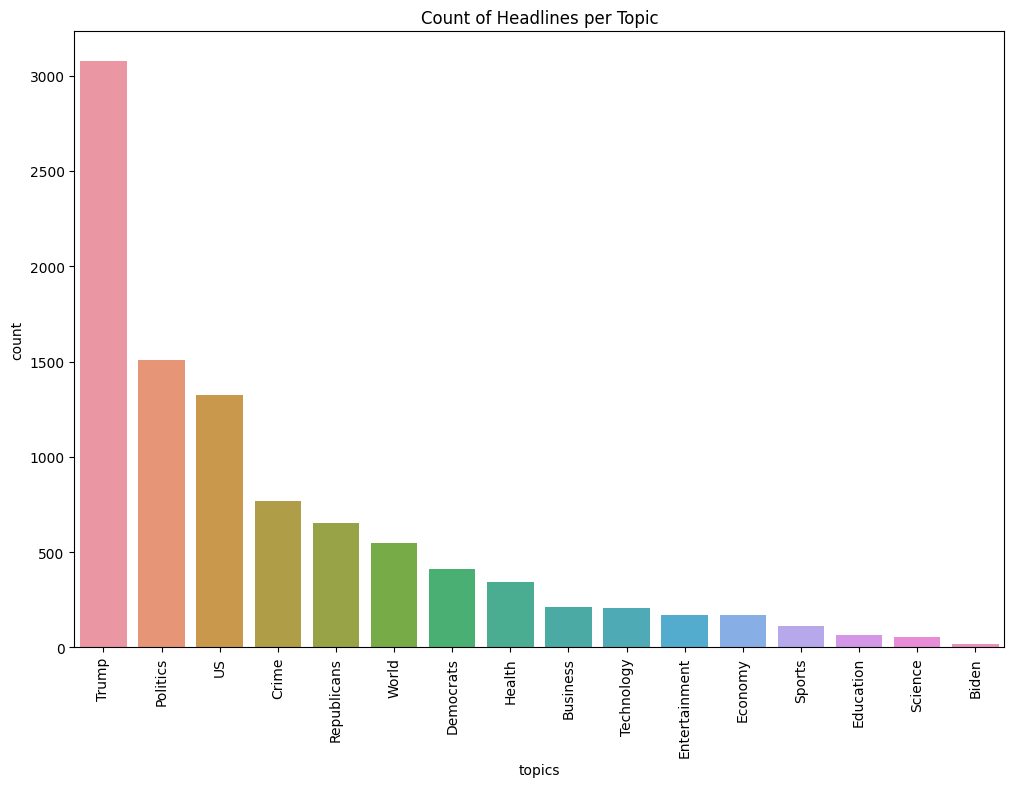

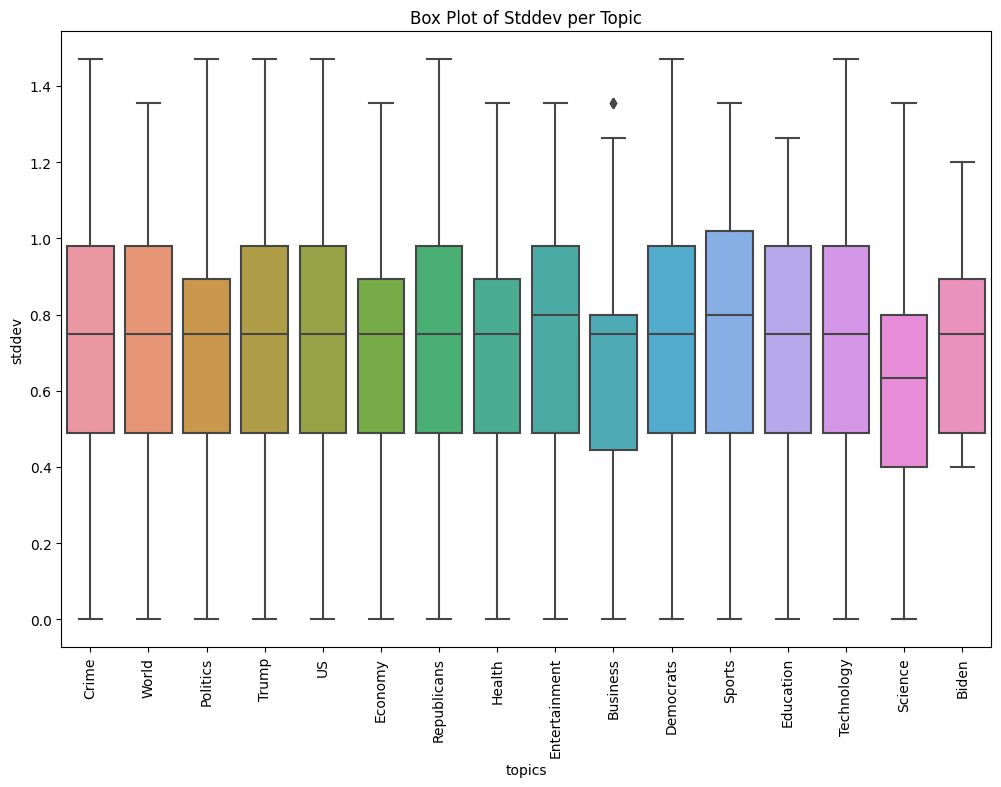

In [10]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()


9652


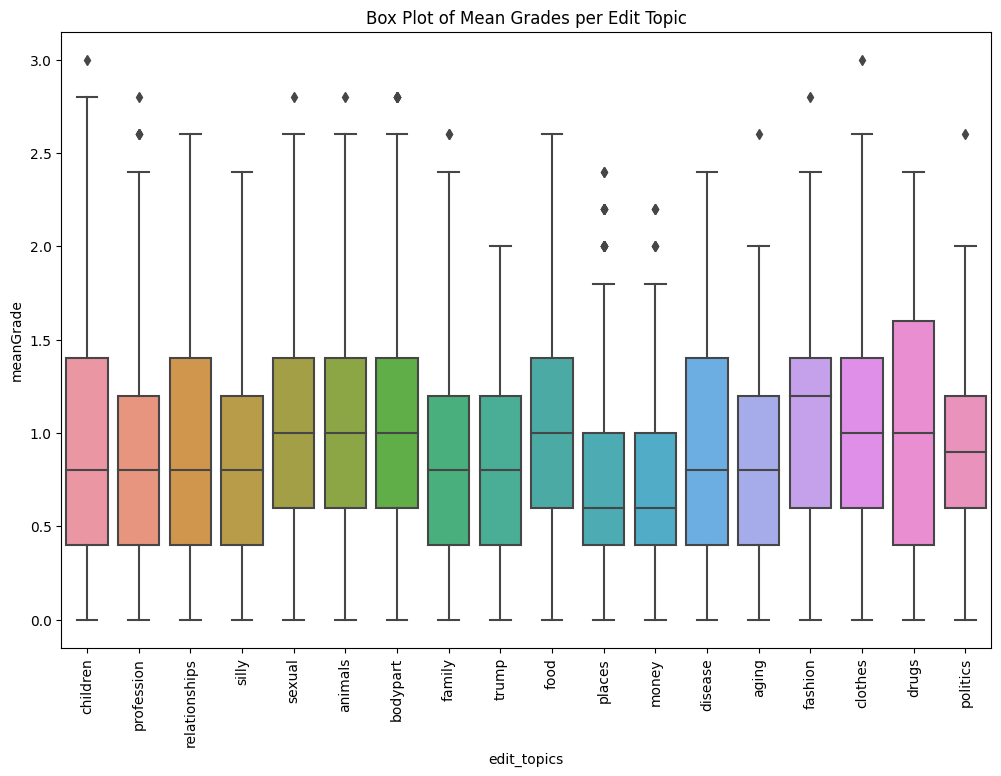

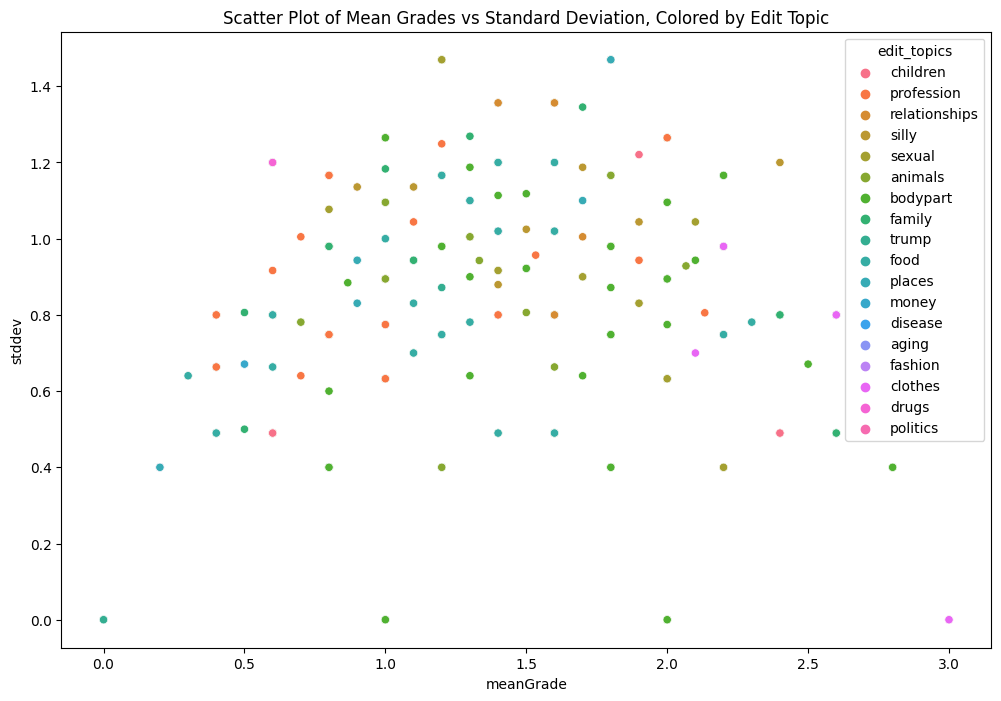

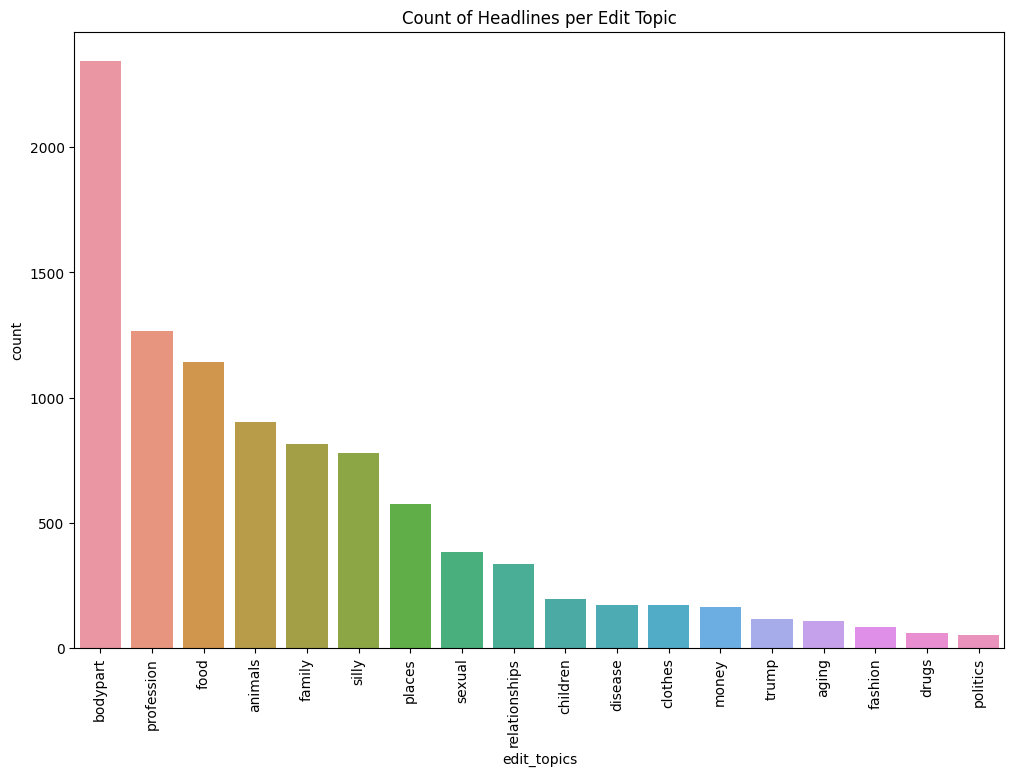

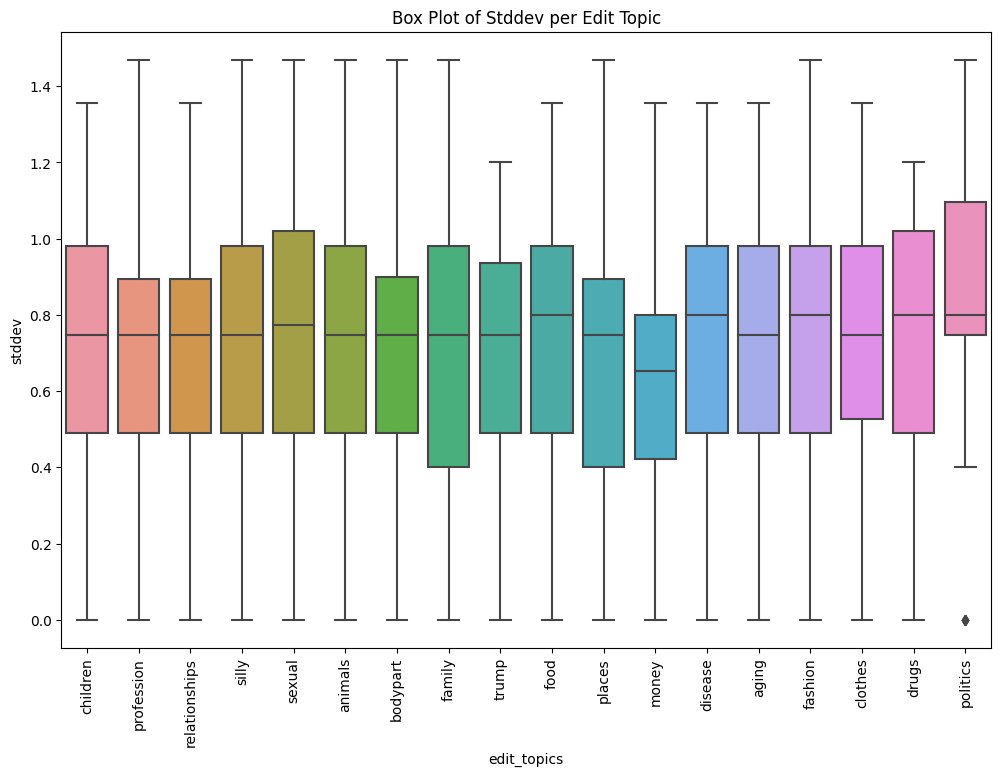

In [11]:
print(len(df.index))

# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_edit_topics = df.copy()
df_edit_topics['edit_topics'] = df['edit_topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="meanGrade", data=df_edit_topics)
plt.title('Box Plot of Mean Grades per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="edit_topics", data=df_edit_topics)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Edit Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of edit_topics
plt.figure(figsize=(12, 8))
sns.countplot(x="edit_topics", data=df_edit_topics, order = df_edit_topics['edit_topics'].value_counts().index)
plt.title('Count of Headlines per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="stddev", data=df_edit_topics)
plt.title('Box Plot of Stddev per Edit Topic')
plt.xticks(rotation=90)
plt.show()


In [12]:
agreement_names = ['All Agree', 'One Disagreement', 'Two Disagreements', 'Three Disagreements']

def deconstruct_by_agreeableness(df):
    df_all_agree = df[df['disagreements'] == 0]
    df_one_disagree = df[df['disagreements'] == 1]
    df_two_disagree = df[df['disagreements'] == 2]
    df_three_disagree = df[df['disagreements'] == 3]
    return df_all_agree, df_one_disagree, df_two_disagree, df_three_disagree

df_all_agree, df_one_disagree, df_two_disagree, df_three_disagree = deconstruct_by_agreeableness(df)

0
1
2
3


/tmp/ipykernel_20611/963265126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agreement['topics'] = df['topics'].apply(lambda ts: ts[0])


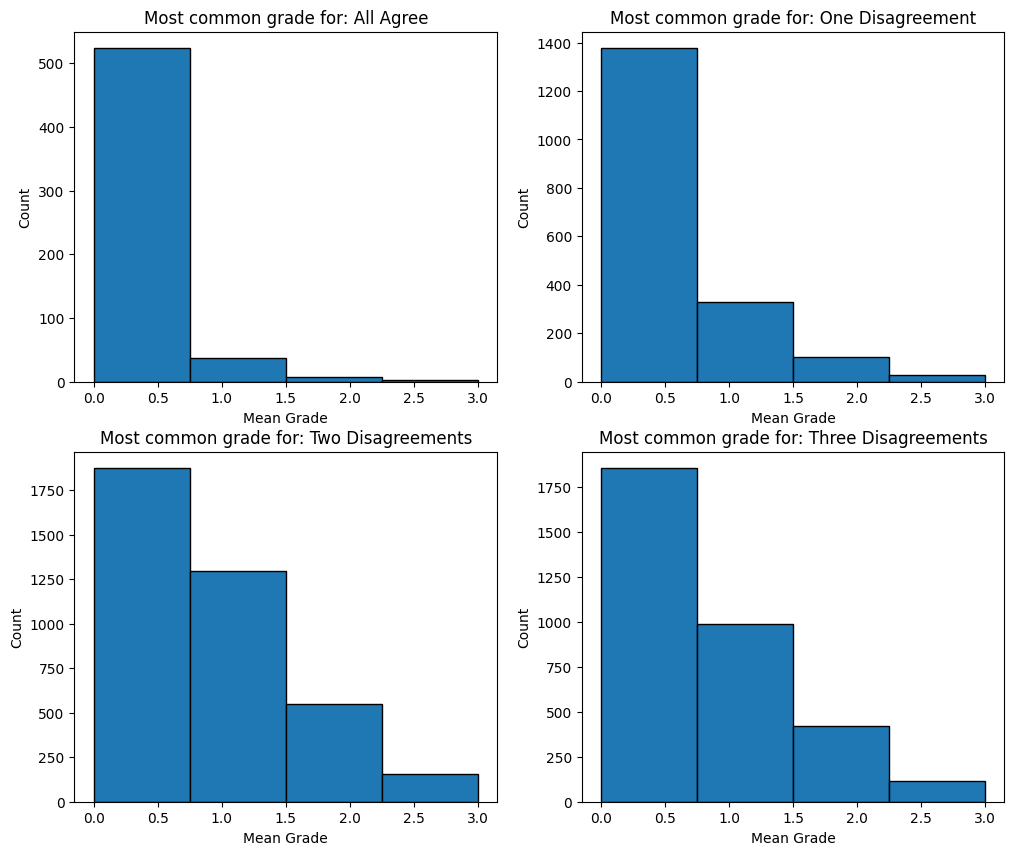

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
dfs = deconstruct_by_agreeableness(df)
for i, df_agreement in enumerate(dfs):
    print(i)
    # remove all where topic is trump
    df_agreement['topics'] = df['topics'].apply(lambda ts: ts[0])
    df_agreement = df_agreement[df_agreement['topics'] != 'trump']

    axs[i // 2, i % 2].hist(df_agreement['most_common_grade'], bins=4, edgecolor='black')
    axs[i // 2, i % 2].set_title(f"Most common grade for: {agreement_names[i]}")
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')

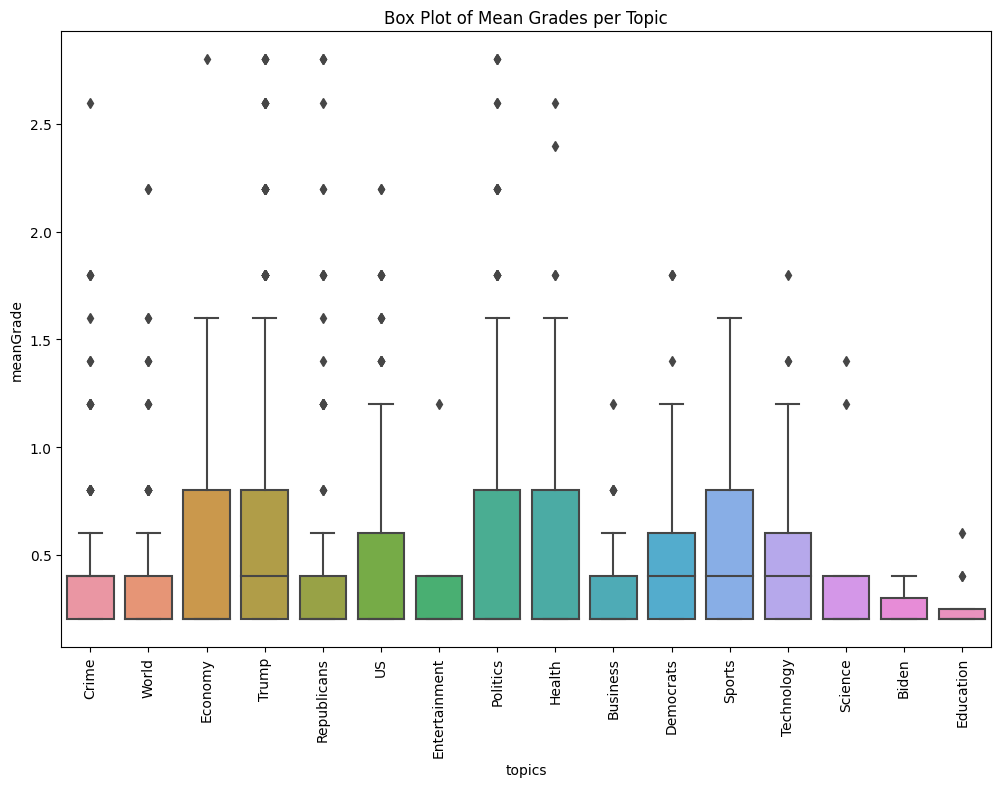

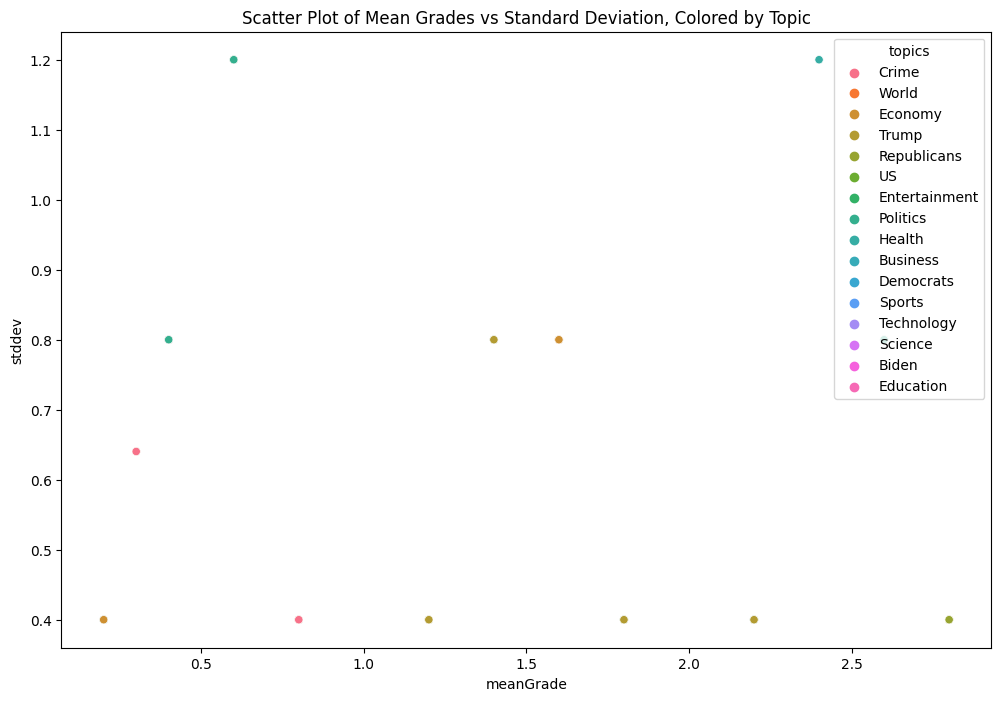

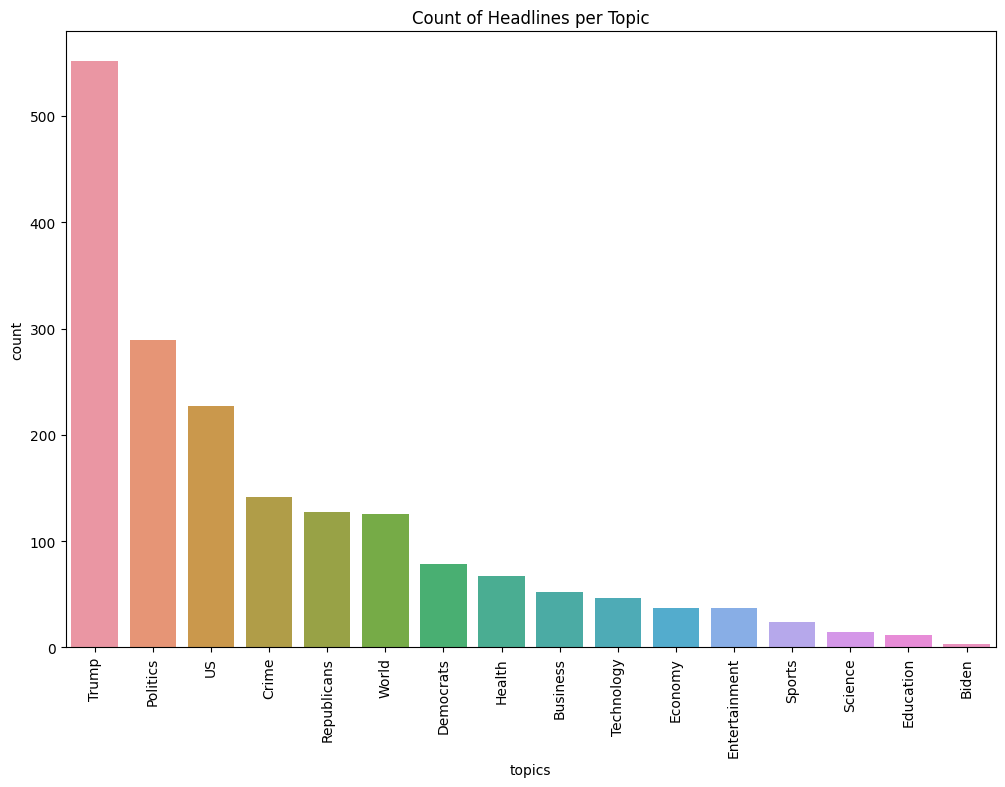

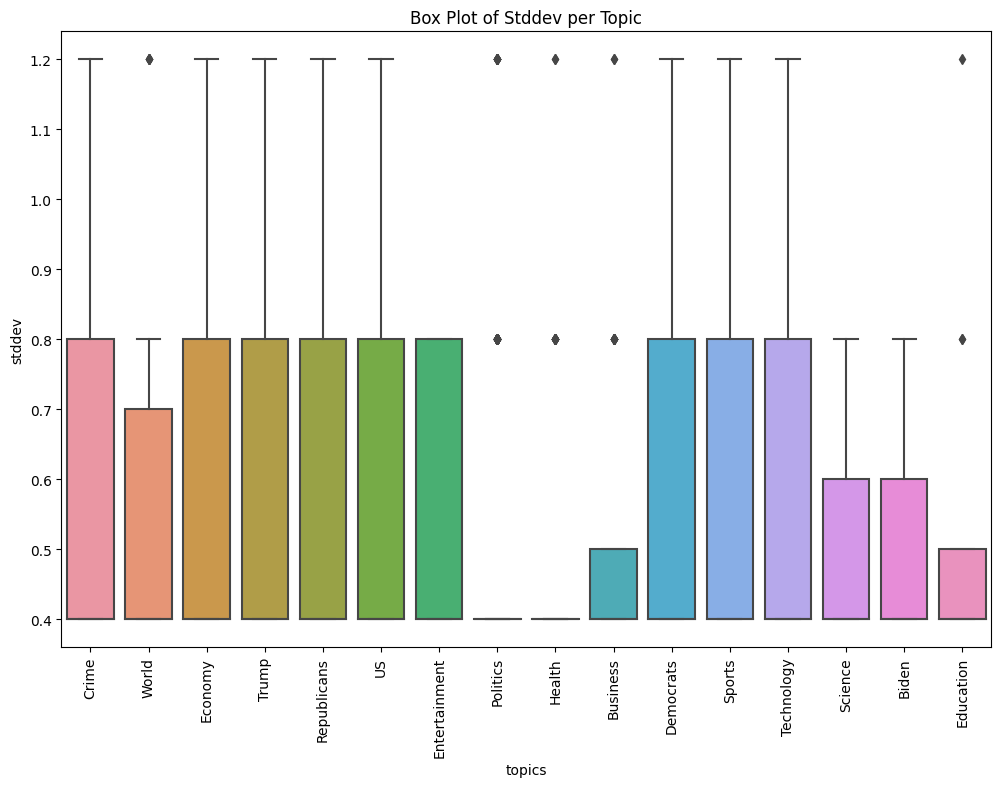

In [14]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df_one_disagree.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# for each topic, get the mean most common grade and stddev for most common grade, and set as new cols
df_exploded['most_common_grade'] = df_exploded['most_common_grade'].astype(float)
df_exploded['mean_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('mean')
df_exploded['stddev_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('std')

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()

In [15]:
from transformers import AutoTokenizer, AutoModel
from model_test import fit_regression, compute_metrics_regression
from data import TokenizedSentencesDataset

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model, trainer = fit_regression('sentence-transformers/all-MiniLM-L6-v2', './fit_out', train_df, val_df, test_df)

2023-05-31 23:31:19 - Loading faiss with AVX2 support.
2023-05-31 23:31:19 - Successfully loaded faiss with AVX2 support.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/gabriel/miniconda3/envs/tarp/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'eval_loss': 0.041517551988363266, 'eval_mae': 0.481158945840368, 'eval_mse': 0.3736579819090685, 'eval_rmse': 0.6112757004078181, 'eval_runtime': 0.8552, 'eval_samples_per_second': 2828.535, 'eval_steps_per_second': 22.217, 'epoch': 0.41}
{'eval_loss': 0.03682834282517433, 'eval_mae': 0.47311452833174084, 'eval_mse': 0.3314550775192662, 'eval_rmse': 0.5757213540587722, 'eval_runtime': 0.8504, 'eval_samples_per_second': 2844.525, 'eval_steps_per_second': 22.342, 'epoch': 0.83}
{'eval_loss': 0.03601992502808571, 'eval_mae': 0.46786740859612397, 'eval_mse': 0.3241793022321971, 'eval_rmse': 0.5693674580024723, 'eval_runtime': 0.8523, 'eval_samples_per_second': 2838.211, 'eval_steps_per_second': 22.293, 'epoch': 1.24}
{'eval_loss': 0.03499937430024147, 'eval_mae': 0.4592995434174019, 'eval_mse': 0.3149943878968804, 'eval_rmse': 0.5612436083349907, 'eval_runtime': 0.8553, 'eval_samples_per_second': 2828.323, 'eval_steps_per_second': 22.215, 'epoch': 1.65}
{'loss': 0.0491, 'learning_rate': 

152
Metrics for All Agree, grade 0: {'mae': 0.8501483794105681, 'mse': 0.7389484706865799, 'rmse': 0.8596211204284012}
16
Metrics for All Agree, grade 1: {'mae': 0.09528842195868492, 'mse': 0.017667867292894934, 'rmse': 0.1329205299902725}
2
Metrics for All Agree, grade 2: {'mae': 0.7889165878295898, 'mse': 0.622929362416528, 'rmse': 0.7892587423757357}
170
Metrics for All Agree, combined grades: {'mae': 0.7783823616364423, 'mse': 0.6696983034125477, 'rmse': 0.8183509659141044}
391


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


Metrics for One Disagreement, grade 0: {'mae': 0.6055575552041573, 'mse': 0.4033827445244131, 'rmse': 0.6351241961415208}
87
Metrics for One Disagreement, grade 1: {'mae': 0.22339447476397986, 'mse': 0.07008265144476918, 'rmse': 0.26473128157580694}
27
Metrics for One Disagreement, grade 2: {'mae': 0.8909837029598378, 'mse': 0.8756515726582325, 'rmse': 0.9357625621161773}
7
Metrics for One Disagreement, grade 3: {'mae': 1.6222595487322127, 'mse': 2.662991283390459, 'rmse': 1.6318674221242542}
512


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Metrics for One Disagreement, combined grades: {'mae': 0.5695716793998145, 'mse': 0.40254565319564883, 'rmse': 0.63446485576086}
625
Metrics for Two Disagreements, grade 0: {'mae': 0.3387557354927063, 'mse': 0.15178249975179342, 'rmse': 0.3895927357533677}
383
Metrics for Two Disagreements, grade 1: {'mae': 0.3049518546921155, 'mse': 0.1328020730950422, 'rmse': 0.36442018755146127}
180


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


Metrics for Two Disagreements, grade 2: {'mae': 0.660824426677492, 'mse': 0.5533835456243269, 'rmse': 0.7438975370468213}
39
Metrics for Two Disagreements, grade 3: {'mae': 1.2676827342082293, 'mse': 1.7045051823408408, 'rmse': 1.3055669964964804}
1227


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


Metrics for Two Disagreements, combined grades: {'mae': 0.40497711167261674, 'mse': 0.25412550341988993, 'rmse': 0.5041086226398929}
599
Metrics for Three Disagreements, grade 0: {'mae': 0.20453843976898067, 'mse': 0.06997927696738784, 'rmse': 0.2645359653570528}
337
Metrics for Three Disagreements, grade 1: {'mae': 0.4949957116421323, 'mse': 0.32341317396257346, 'rmse': 0.568694271082955}
140
Metrics for Three Disagreements, grade 2: {'mae': 0.8278450927564076, 'mse': 0.7549903530891241, 'rmse': 0.8689018086579887}
39


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({
/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


Metrics for Three Disagreements, grade 3: {'mae': 0.8555630476046832, 'mse': 0.7459434638795994, 'rmse': 0.8636801861103446}
1115


/tmp/ipykernel_20611/2809099789.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


Metrics for Three Disagreements, combined grades: {'mae': 0.39336085223296297, 'mse': 0.2562316300842936, 'rmse': 0.5061932734482884}


/tmp/ipykernel_20611/2809099789.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({


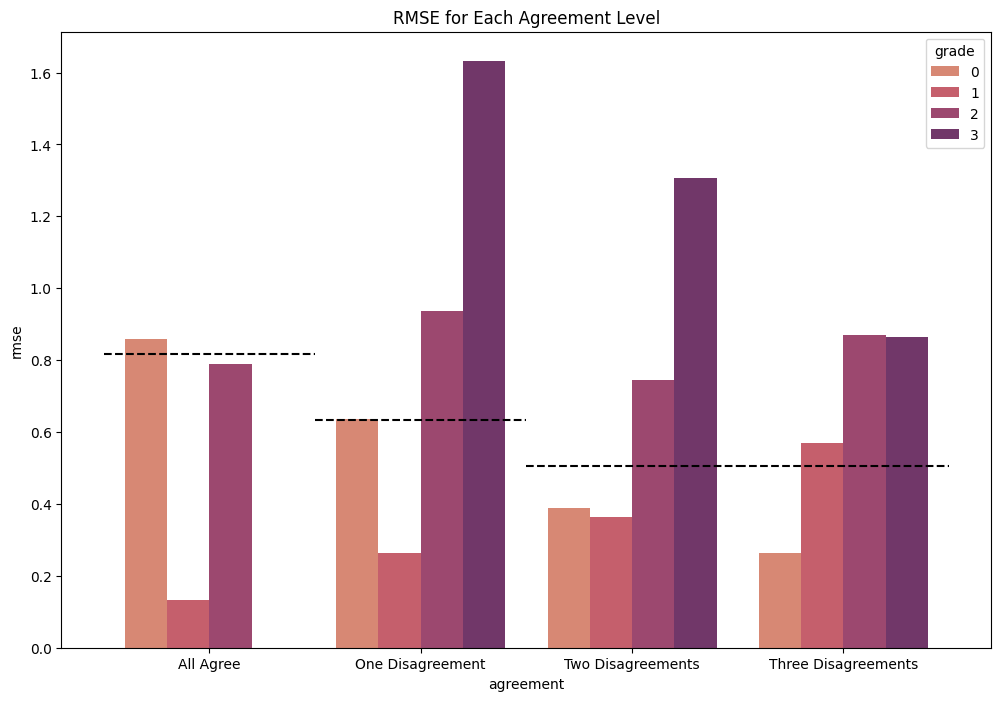

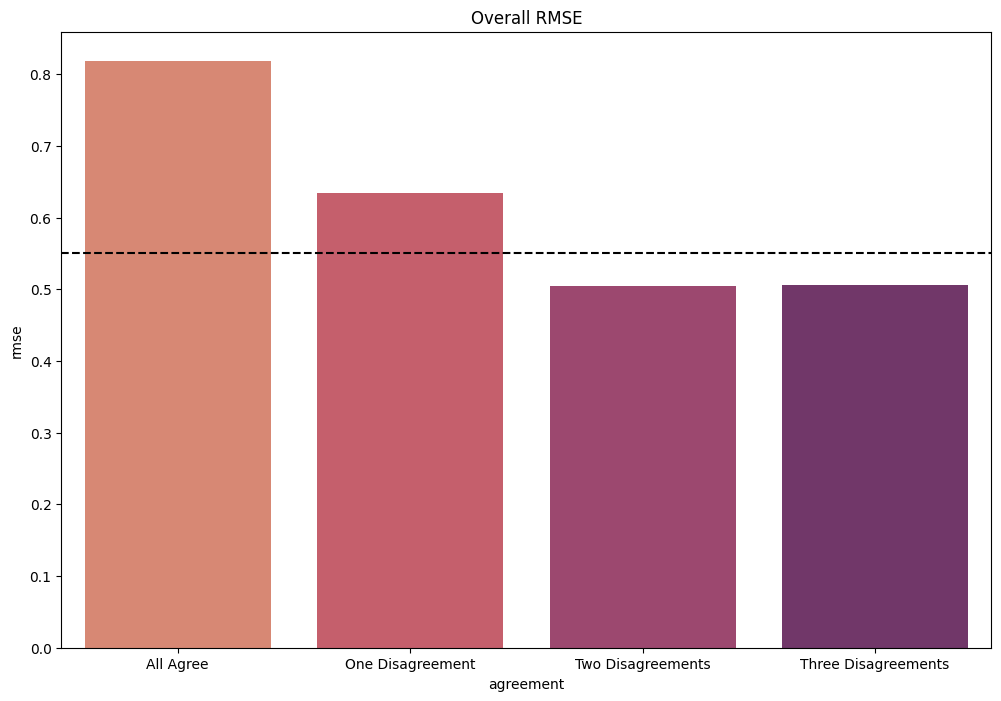

In [56]:
class TokenizedSentencesDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.df = dataframe
        
        original = self.df["original_sentence"].tolist()
        edited   = self.df["edited_sentence"].tolist()
        text = [f"{o} [SEP] {e}" for o, e in zip(original, edited)]
        print(len(text))
        output = tokenizer(text=text, truncation=True, padding=True, return_tensors='pt')
        
        self.input_ids      = output["input_ids"]
        self.attention_mask = output["attention_mask"]
        #self.labels         = torch.tensor(self.df['most_common_grade'].values, dtype=torch.float32)
        self.labels         = torch.tensor(self.df['normalized_score'].values, dtype=torch.float32)
    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels":         self.labels[idx],
        }

# put computed metrics into new dataframe
df_metrics = pd.DataFrame(columns=['agreement', 'grade', 'pearson', 'spearman', 'rmse'])
overall_mses = []
for i, df_agreement in enumerate(deconstruct_by_agreeableness(test_df)):
    for grade in range(0, 3+1):
        df_agrement_and_grade = df_agreement[df_agreement['most_common_grade'] == grade]
        if len(df_agrement_and_grade) == 0:
            continue
        out = trainer.predict(TokenizedSentencesDataset(tokenizer, df_agrement_and_grade))
        metrics = compute_metrics_regression((out.predictions, out.label_ids))
        print(f"Metrics for {agreement_names[i]}, grade {grade}: {metrics}")

        # store metric in dataframe
        df_metrics = df_metrics.append({
            'agreement': agreement_names[i],
            'grade': grade,
            #'pearson': metrics['pearson'],
            #'spearman': metrics['spearman'],
            'rmse': metrics['rmse'],
        }, ignore_index=True)
    
    out = trainer.predict(TokenizedSentencesDataset(tokenizer, df_agreement))
    metrics = compute_metrics_regression((out.predictions, out.label_ids))
    df_metrics = df_metrics.append({
            'agreement': agreement_names[i],
            'grade': -1,
            #'pearson': metrics['pearson'],
            #'spearman': metrics['spearman'],
            'rmse': metrics['rmse'],
        }, ignore_index=True)
    overall_mses.append(metrics['rmse'])

    print(f"Metrics for {agreement_names[i]}, combined grades: {metrics}")

# separate barplot of rmse for each agreement level
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="agreement", y="rmse", hue="grade", data=df_metrics[df_metrics['grade'] != -1], palette="flare")
ax.hlines(
    y=overall_mses, 
    xmin=[i-0.5 for i in range(len(overall_mses))],
    xmax=[i+0.5 for i in range(len(overall_mses))], 
    ls='--', color='black'
)
plt.title('RMSE for Each Agreement Level')
#plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(12, 8))
ax = sns.barplot(x="agreement", y="rmse", data=df_metrics[df_metrics['grade'] == -1], palette="flare")
ax.axhline(0.55, ls='--', color='black')
plt.title('Overall RMSE')
#plt.xticks(rotation=90)
plt.show()

print(df_metrics[(df_metrics['grade'] == 3) & (df_metrics['agreement'] == 'All Agree')])

In [57]:
print(df_metrics[(df_metrics['grade'] == 3) & (df_metrics['agreement'] == 'All Agree')])

Empty DataFrame
Columns: [agreement, grade, pearson, spearman, rmse]
Index: []


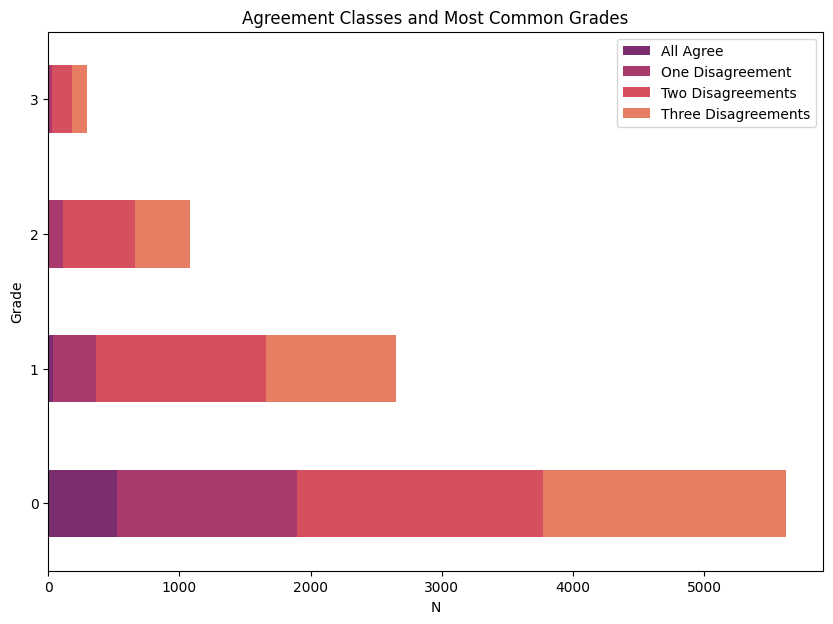

In [17]:
dfs = deconstruct_by_agreeableness(df)

# Compute grade counts for each dataframe
grade_counts = [df['most_common_grade'].value_counts(normalize=False) for df in dfs]

# Convert grade counts to a DataFrame
grade_counts_df = pd.DataFrame(grade_counts).T
grade_counts_df.columns = agreement_names

# Plot
grade_counts_df.plot(kind='barh', stacked=True, figsize=(10, 7), color=sns.color_palette("flare", n_colors=4)[::-1])
plt.title('Agreement Classes and Most Common Grades')
plt.xlabel('N')
plt.ylabel('Grade')
plt.show()

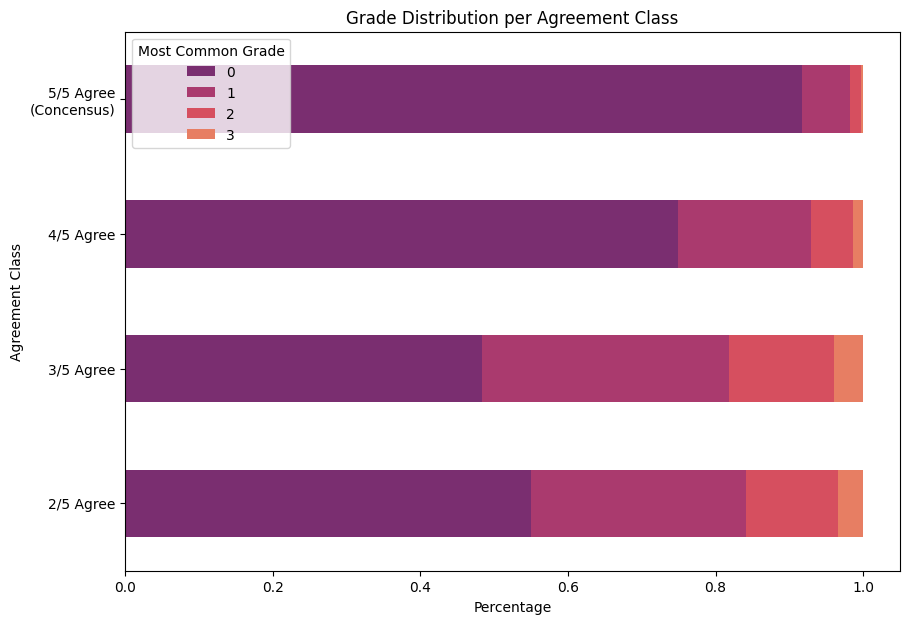

In [18]:
# Compute disagreement counts for each dataframe
disagreement_counts = [df['most_common_grade'].value_counts(normalize=True) for df in dfs]

# Convert disagreement counts to a DataFrame
disagreement_counts_df = pd.DataFrame(disagreement_counts).T
disagreement_counts_df.columns = ['5/5 Agree\n(Concensus)', '4/5 Agree', '3/5 Agree', '2/5 Agree']

# Transpose the DataFrame to get disagreement classes as bars
disagreement_counts_df = disagreement_counts_df.transpose()

# Plot
cmap = sns.color_palette("flare", n_colors=4)[::-1]

disagreement_counts_df.plot(kind='barh', stacked=True, figsize=(10, 7), color=cmap).invert_yaxis()
plt.title('Grade Distribution per Agreement Class')
plt.xlabel('Percentage')
plt.ylabel('Agreement Class')
plt.legend(title='Most Common Grade')
plt.show()


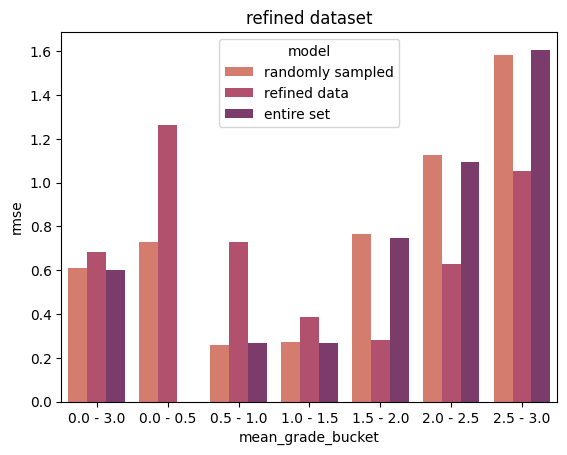

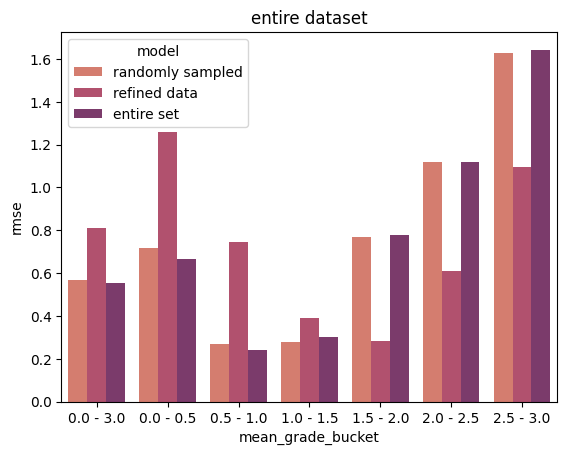

In [66]:
 
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 0 (threshold 0.8): {'mae': 0.7708974409103394, 'mse': 0.7549566245722571, 'rmse': 0.8688823997367291}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 0 (threshold 0.8): {'mae': 1.1947281217575074, 'mse': 1.6457225016459205, 'rmse': 1.2828571633841082}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 0 (threshold 0.8): {'mae': 0.8496183668865877, 'mse': 0.8022210720854362, 'rmse': 0.8956679474478454}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 0 (threshold 0.8): {'mae': 1.3842397381277645, 'mse': 2.0110816431274294, 'rmse': 1.4181261026888368}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 1 (threshold 0.8): {'mae': 0.5950841200351715, 'mse': 0.4587049847721751, 'rmse': 0.677277627544403}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 1 (threshold 0.8): {'mae': 0.9578437507152557, 'mse': 1.104062448594309, 'rmse': 1.0507437597218023}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 1 (threshold 0.8): {'mae': 0.6172205818002112, 'mse': 0.45669913798666817, 'rmse': 0.6757951893781637}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 1 (threshold 0.8): {'mae': 1.0630526703898795, 'mse': 1.2588998793999693, 'rmse': 1.122007076359133}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 2 (threshold 0.8): {'mae': 0.5152952637684558, 'mse': 0.4047397753387257, 'rmse': 0.636191618412822}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 2 (threshold 0.8): {'mae': 0.5900502785774892, 'mse': 0.48183372218797293, 'rmse': 0.6941424365272396}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 2 (threshold 0.8): {'mae': 0.4306439177331248, 'mse': 0.2720599061841849, 'rmse': 0.5215936216866393}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 2 (threshold 0.8): {'mae': 0.7028733493840684, 'mse': 0.6203621750667347, 'rmse': 0.7876307352222454}
#{ 'dataset': 'KEPT'   model: 'randomly sampled',  disagreement 3 (threshold 0.8): {'mae': 0.4303677698520765, 'mse': 0.2950672052133709, 'rmse': 0.5432008884504617}
#{ 'dataset': 'KEPT'   model: 'refined data',      disagreement 3 (threshold 0.8): {'mae': 0.3773945832633537, 'mse': 0.20071710776042836, 'rmse': 0.4480146289580602}
#{ 'dataset': 'ENTIRE' model: 'randomly sampled',  disagreement 3 (threshold 0.8): {'mae': 0.38164039871617816, 'mse': 0.2424444785399681, 'rmse': 0.4923865133611684}
#{ 'dataset': 'ENTIRE' model: 'refined data',      disagreement 3 (threshold 0.8): {'mae': 0.4021579368232077, 'mse': 0.22083215462270328, 'rmse': 0.46992781852397636}

#KEPT   dataset, entire set model, disagreement 0 (threshold 0.8): {'mae': 0.7413814520835876, 'mse': 0.7024504329416097, 'rmse': 0.8381231609624028}
#KEPT   dataset, kept-only        model, disagreement 0 (threshold 0.8): {'mae': 1.2192668390274048, 'mse': 1.7215445900930462, 'rmse': 1.3120764421683084}
#ENTIRE dataset, entire set model, disagreement 0 (threshold 0.8): {'mae': 0.7974914252758026, 'mse': 0.7029073651703219, 'rmse': 0.8383957091793361}
#ENTIRE dataset, kept-only        model, disagreement 0 (threshold 0.8): {'mae': 1.3947345298879288, 'mse': 2.046829373529656, 'rmse': 1.4306744470806962}
#KEPT   dataset, entire set model, disagreement 1 (threshold 0.8): {'mae': 0.586527540922165, 'mse': 0.446907995741235, 'rmse': 0.6685117768156632}
#KEPT   dataset, kept-only        model, disagreement 1 (threshold 0.8): {'mae': 0.9625296218395233, 'mse': 1.1041413820081165, 'rmse': 1.050781319784529}
#ENTIRE dataset, entire set model, disagreement 1 (threshold 0.8): {'mae': 0.5768714070436545, 'mse': 0.41018517171680546, 'rmse': 0.6404570022388744}
#ENTIRE dataset, kept-only        model, disagreement 1 (threshold 0.8): {'mae': 1.0701831144397147, 'mse': 1.2728756160988088, 'rmse': 1.128217893892314}
#KEPT   dataset, entire set model, disagreement 2 (threshold 0.8): {'mae': 0.5172069427621273, 'mse': 0.40481194649308855, 'rmse': 0.6362483371240263}
#KEPT   dataset, kept-only        model, disagreement 2 (threshold 0.8): {'mae': 0.58880672397201, 'mse': 0.4808566933091022, 'rmse': 0.6934383125477724}
#ENTIRE dataset, entire set model, disagreement 2 (threshold 0.8): {'mae': 0.4077129732960108, 'mse': 0.2566611542477327, 'rmse': 0.5066173647317399}
#ENTIRE dataset, kept-only        model, disagreement 2 (threshold 0.8): {'mae': 0.706048510962613, 'mse': 0.6227710308918454, 'rmse': 0.7891584320602837}
#KEPT   dataset, entire set model, disagreement 3 (threshold 0.8): {'mae': 0.4178176676029484, 'mse': 0.27900516632344835, 'rmse': 0.5282093962847011}
#KEPT   dataset, kept-only        model, disagreement 3 (threshold 0.8): {'mae': 0.3797878618926218, 'mse': 0.20275371804176529, 'rmse': 0.4502818206876281}
#ENTIRE dataset, entire set model, disagreement 3 (threshold 0.8): {'mae': 0.3868751161836188, 'mse': 0.24948764664997905, 'rmse': 0.4994873838746871}
#ENTIRE dataset, kept-only        model, disagreement 3 (threshold 0.8): {'mae': 0.40747104749551266, 'mse': 0.22633906634991705, 'rmse': 0.47575105501713505}
#KEPT   dataset, entire set model, meanGrade 0.0-0.5 (threshold 0.8): {'mae': 0.7045136007997724, 'mse': 0.5272123278862542, 'rmse': 0.7260938836584799}

{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2640821777011984 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2658762338133176 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7409811463413085 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7535737631897971 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3892582724031099 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3995633921945709 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.27838517310414024 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.27338923178002955 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.609835113508833 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.594459892897418 },
{ 'dataset': 'KEPT',   'model': 'kept-only',        'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.0530526028551583 },
{ 'dataset': 'ENTIRE', 'model': 'kept-only',        'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.091694462311364 },


dinky_df = pd.DataFrame([
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.60956878995761 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.682103854550248 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.5676318313297427 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.8119993111375877 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.7282226979173854 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2630974437920222 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.7163780496513894 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.0 - 0.5', 'rmse': 1.2608005140785197 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.25779537198923363 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7298437438630255 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.2681923719980645 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.7448765000354526 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.2710464052438125 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.38479189205515074 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.27989636911271265 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3898444133812833 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.7654630273267387 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.28044292075600924 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.770540437243583 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.28219939850449705 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.1279920300625925 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.6287969027249929 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.119837179152282 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '2.0 - 2.5', 'rmse': 0.6114348602316309 },
    { 'dataset': 'KEPT',    'model': 'randomly sampled', 'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.5829224580131365 },
    { 'dataset': 'KEPT',    'model': 'refined data',     'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.052275605984535 },
    { 'dataset': 'ENTIRE',  'model': 'randomly sampled', 'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6270095279643135 },
    { 'dataset': 'ENTIRE',  'model': 'refined data',     'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.0933530581020658 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.6013238178882069 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.0 - 3.0', 'rmse': 0.5523551715028504 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.0 - 0.5', 'rmse': 0.6673708202475422 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.2661807776188036 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '0.5 - 1.0', 'rmse': 0.24179993696017035 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.26665174124692165 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '1.0 - 1.5', 'rmse': 0.3001270171622522 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.745534987183211 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '1.5 - 2.0', 'rmse': 0.7778305909162193 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.0956012691388783 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '2.0 - 2.5', 'rmse': 1.119018057863962 },
    { 'dataset': 'KEPT',    'model': 'entire set',       'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6075678009840064 },
    { 'dataset': 'ENTIRE',  'model': 'entire set',       'mean_grade_bucket': '2.5 - 3.0', 'rmse': 1.6434596593670368 },
])

sns.barplot(x='mean_grade_bucket', y='rmse', hue='model', palette='flare', data=dinky_df[dinky_df['dataset'] == 'KEPT'])
plt.title("refined dataset")
plt.show()
sns.barplot(x='mean_grade_bucket', y='rmse', hue='model', palette='flare', data=dinky_df[dinky_df['dataset'] == 'ENTIRE'])
plt.title("entire dataset")
plt.show()